# Procedure for quantum state preparation (QSP) experiment.

QSP is presented clearly in [this publication](https://arxiv.org/abs/2306.17422). The basic idea is that we have two unitary $U(\theta)$ and $V^{\dagger}$, we optimize the parameter $\theta$ until $\theta^{*}$ such that $U(\theta^{*})V^{\dagger}=I$.

So we will do experiments with various $U$, $V^{\dagger}$ and optimize strategy. 

Some notation for hyperparameter:

(important)
- Ansatz: $U$ (defined in `qtm.ansatz`)
- Optimize circuit: $u$ (ansatz when repeat $L$ times)
- State: $V^{\dagger}$ (defined in `qtm.state`)
- Number of qubit: $n$ (`num_qubits`)
- Number of layer (for ansatz): $L$ (`num_layers`)
- $\theta$: theta (if $\theta$ is scalar), thetas (if $\theta$ is 1-d numpy array) and thetass (if $\theta$ is 2-d numpy array).

(not important)
- Number of iteration: $n_{iter}$ (`num_iter / iter`)
- Optimizer: `sgd`, `adam` or `qng` family, the best optimizer is `adam`.

Here is your task, run the below codes with:

- $U$ is `qtm.ansatz.g2`, `qtm.ansatz.g2gn` or `qtm.ansatz.g2gnw`.
- $V^{\dagger}$ is `qtm.state.create_GHZ_state(num_qubits).inverse()`, `qtm.state.create_W_state(num_qubits).inverse()`, `qtm.state.create_AME_state(num_qubits).inverse()` or `qtm.state.create_haar_state_inverse(num_qubits)`
- $n$ from 3 - 10 (3 - 5 for AME state).
- $L$ from 1 - 10 (Note: if we run L = 3 and achieve fidelity ~ 0, then no need to run with larger $L$).
- $n_{iter}$: default is 100, if loss value is not ~ 0, you can plot loss_values curve by compiler.plot() method, if it can decrease in the next iteration, then increasing $n_{iter}$ upto 300.

The detailed guideline is below. If you can use the server A6000, let's view `multi_process_script.py`.

In [2]:
import sys
sys.path.insert(0, '..')
from qsee.compilation.qsp import QuantumStatePreparation
from qsee.core import ansatz, state
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

### Quantum State Preparation (QSP) problem

First, using Quantum Compilation (QC) to find optimized $\theta$

In [47]:
num_qubits = 3
num_layers = 1
qsp = QuantumStatePreparation(
    u = ansatz.g2gn(num_qubits, num_layers),
    target_state = state.w(num_qubits).inverse(),
)
qsp.fit(num_steps = constant.DEFAULT_NUM_STEPS, verbose = 1, optimizer = 'adam')

Step: 100%|██████████| 100/100 [00:03<00:00, 28.53it/s]


In [52]:
target_state = np.array(np.random.uniform(size=2**3))
from qsee.compilation.qsp import QuantumStatePreparation
compiler = QuantumStatePreparation.prepare(target_state)
compiler.fit()

AttributeError: 'QuantumCompilation' object has no attribute 'compilation_fidelities'

In [42]:
compiler2 = QuantumCompilation.prepare(target_state)
compiler2.fit(30)

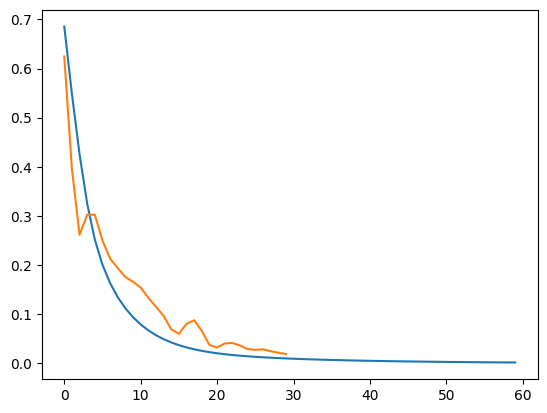

In [43]:
plt.plot(compiler.metrics['loss_fubini_study'])
plt.plot(compiler2.metrics['loss_fubini_study'])

**Important**, you must save the result in the folder experiments/qsp/, where the 'state' argument is the name of state which is need to prepare. The name of file will be automatically create followed this format:

```
[state]_[ansatz]_[num_qubits]_[num_layers].qspobj
```

Last step, load QSP from saved file and check its properties.

In [36]:
qspobj = QuantumStatePreparation.load('../experiments/test')
qspobj.fidelity

0.9998482451406707

In [8]:
obj = QuantumStatePreparation.prepare('ghz', num_qubits = 3)

     ┌──────────────┐                ┌──────────────┐      ┌──────────────┐   
q_0: ┤ Ry(theta[0]) ├───────■────────┤ Ry(theta[3]) ├────■─┤ Ry(theta[6]) ├─■─
     ├──────────────┤       │        ├──────────────┤    │ ├──────────────┤ │ 
q_1: ┤ Ry(theta[1]) ├───────■────────┤ Ry(theta[4]) ├─■──┼─┤ Ry(theta[7]) ├─■─
     ├──────────────┤┌──────────────┐└──────────────┘ │  │ ├──────────────┤ │ 
q_2: ┤ Ry(theta[2]) ├┤ Ry(theta[5]) ├─────────────────■──■─┤ Ry(theta[8]) ├─■─
     └──────────────┘└──────────────┘                      └──────────────┘   
can prepare the state ghz 3 qubits >= 0.99 fidelity (0.9998482451406707)


In [35]:
obj.save('../experiments/test')